# Predicting Financial Crisis: Study A x Processing 2

Using the Financial Crises dataset: characterize/describe the dataset and compare various classification models (e.g., Logistic regression, SVM, NN, classification trees/forests, ... ) in terms of their ability to correctly predict financial crises. Make sure to treat this as a real-time prediction problem: when predicting financial crises is a given year t, you can only use features from previous years t-s (with s>0), but no contemporaneous variables from the same year t. Compare the quality of your predictions using different criteria and validation methods.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split, cross_val_predict, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn import preprocessing
from sklearn.metrics import precision_score, recall_score, f1_score, r2_score, mean_squared_error, confusion_matrix
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, average_precision_score
from math import sqrt
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv('FinancialCrises.csv')

## Data Processing

In [3]:
df = df[['year', 'country', 'loans1', 'cpi', 'crisisST']]

In [4]:
df1 = df.loc[df['country'] == 'DNK']
df2 = df.loc[df['country'] == 'AUS']
df3 = df.loc[df['country'] == 'JPN']
df4 = df.loc[df['country'] == 'ESP']
df5 = df.loc[df['country'] == 'GBR']
df6 = df.loc[df['country'] == 'SWE']
df7 = df.loc[df['country'] == 'FRA']
df8 = df.loc[df['country'] == 'NOR']
df9 = df.loc[df['country'] == 'USA']
df10 = df.loc[df['country'] == 'ITA']
df11 = df.loc[df['country'] == 'DEU']
df12 = df.loc[df['country'] == 'CAN']
df13 = df.loc[df['country'] == 'NLD']
df14 = df.loc[df['country'] == 'CHE']

In [5]:
def df_process(df):
    df['loans1'] = df['loans1'].fillna(method = 'ffill')
    df['loans1'] = df['loans1'].fillna(method = 'bfill')
    df['cpi'] = df['cpi'].fillna(method = 'ffill')
    df['cpi'] = df['cpi'].fillna(method = 'bfill')
    df = df.sort_values(by=['country', 'year'])
    df['credit_growth'] = np.log(df['loans1']).diff() - np.log(df['cpi']).diff()
    df['CG_lag_1'] = df['credit_growth'].shift(1)
    df['CG_lag_2'] = df['credit_growth'].shift(2)
    df['CG_lag_3'] = df['credit_growth'].shift(3)
    df['CG_lag_4'] = df['credit_growth'].shift(4)
    df['CG_lag_5'] = df['credit_growth'].shift(5)
    df = df[['year', 'country', 'crisisST', 'credit_growth', 'CG_lag_1', 'CG_lag_2', 'CG_lag_3', 'CG_lag_4', 'CG_lag_5']]
    return df

In [6]:
df1 = df_process(df1)
df2 = df_process(df2)
df3 = df_process(df3)
df4 = df_process(df4)
df5 = df_process(df5)
df6 = df_process(df6)
df7 = df_process(df7)
df8 = df_process(df8)
df9 = df_process(df9)
df10 = df_process(df10)
df11 = df_process(df11)
df12 = df_process(df12)
df13 = df_process(df13)
df14 = df_process(df14)

In [7]:
df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14])
df = df.dropna()
enc = LabelEncoder()
df['country'] = enc.fit_transform(df['country'])
df = df.sort_values(by=['year', 'country'])

## Models

In [8]:
n = 4
df = df.set_index(np.arange(len(df)))

### Logistic Regression

In [11]:
clf = LogisticRegression(max_iter = 200, solver = 'newton-cg')

In [12]:
AUC_LR_sm = []
AUC_LR = []
proba_sm = []
proba = []
y_t = []
y = df['crisisST'].values
X = df.drop(['crisisST'], axis=1).values
scaler = StandardScaler()
X  = scaler.fit_transform(X)
sm = SMOTE(0.5,random_state=42)
tscv = TimeSeriesSplit(n_splits=n)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_t.append(y_test)
    X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
    clf.fit(X_train_sm, y_train_sm)
    y_proba1 = clf.predict_proba(X_test)
    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_test)
    AUC_LR.append(roc_auc_score(y_test, y_proba[:,1]))
    proba.append(list(y_proba[:,1]))
    AUC_LR_sm.append(roc_auc_score(y_test, y_proba1[:,1]))
    proba_sm.append(list(y_proba1[:,1]))

In [13]:
def conf_mat(prob, AUC):
    for i in range(n):
        y_pred = []
        for j in range(len(prob[i])):
            if prob[i][j]>0.5:
                y_pred.append(1)
            else: 
                y_pred.append(0)
        print( "-"*80)
        print('AUC Score:', AUC[i])
        print('Confusion_Matrix', i+1)
        print(confusion_matrix(y_t[i],y_pred))
conf_mat(proba, AUC_LR), conf_mat(proba_sm, AUC_LR_sm)

--------------------------------------------------------------------------------
AUC Score: 0.4975324675324675
Confusion_Matrix 1
[[348   2]
 [ 22   0]]
--------------------------------------------------------------------------------
AUC Score: 0.8013094938302694
Confusion_Matrix 2
[[361   0]
 [ 11   0]]
--------------------------------------------------------------------------------
AUC Score: 0.5635135135135135
Confusion_Matrix 3
[[370   0]
 [  2   0]]
--------------------------------------------------------------------------------
AUC Score: 0.6370056497175142
Confusion_Matrix 4
[[354   0]
 [ 18   0]]
--------------------------------------------------------------------------------
AUC Score: 0.45610389610389607
Confusion_Matrix 1
[[313  37]
 [ 20   2]]
--------------------------------------------------------------------------------
AUC Score: 0.7967766305716444
Confusion_Matrix 2
[[339  22]
 [  9   2]]
--------------------------------------------------------------------------------


(None, None)

### Random Forest Classifier

In [14]:
clf = RandomForestClassifier(criterion = 'entropy', max_features = 'auto', min_samples_leaf = 2, min_samples_split = 2,
                            n_estimators = 500)

In [15]:
AUC_LR_sm = []
AUC_LR = []
proba_sm = []
proba = []
y_t = []
y = df['crisisST'].values
X = df.drop(['crisisST'], axis=1).values
scaler = StandardScaler()
X  = scaler.fit_transform(X)
sm = SMOTE(0.5,random_state=42)
tscv = TimeSeriesSplit(n_splits=n)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_t.append(y_test)
    X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
    clf.fit(X_train_sm, y_train_sm)
    y_proba1 = clf.predict_proba(X_test)
    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_test)
    AUC_LR.append(roc_auc_score(y_test, y_proba[:,1]))
    proba.append(list(y_proba[:,1]))
    AUC_LR_sm.append(roc_auc_score(y_test, y_proba1[:,1]))
    proba_sm.append(list(y_proba1[:,1]))

In [16]:
def conf_mat(prob, AUC):
    for i in range(n):
        y_pred = []
        for j in range(len(prob[i])):
            if prob[i][j]>0.5:
                y_pred.append(1)
            else: 
                y_pred.append(0)
        print( "-"*80)
        print('AUC Score:', AUC[i])
        print('Confusion_Matrix', i+1)
        print(confusion_matrix(y_t[i],y_pred))
conf_mat(proba, AUC_LR), conf_mat(proba_sm, AUC_LR_sm)

--------------------------------------------------------------------------------
AUC Score: 0.5412987012987013
Confusion_Matrix 1
[[350   0]
 [ 22   0]]
--------------------------------------------------------------------------------
AUC Score: 0.6272979098463864
Confusion_Matrix 2
[[361   0]
 [ 11   0]]
--------------------------------------------------------------------------------
AUC Score: 0.7695945945945946
Confusion_Matrix 3
[[370   0]
 [  2   0]]
--------------------------------------------------------------------------------
AUC Score: 0.5612052730696798
Confusion_Matrix 4
[[354   0]
 [ 18   0]]
--------------------------------------------------------------------------------
AUC Score: 0.4825974025974026
Confusion_Matrix 1
[[341   9]
 [ 21   1]]
--------------------------------------------------------------------------------
AUC Score: 0.6600352556031226
Confusion_Matrix 2
[[361   0]
 [ 11   0]]
--------------------------------------------------------------------------------
A

(None, None)

### Plots

Average precision-recall score: 0.13


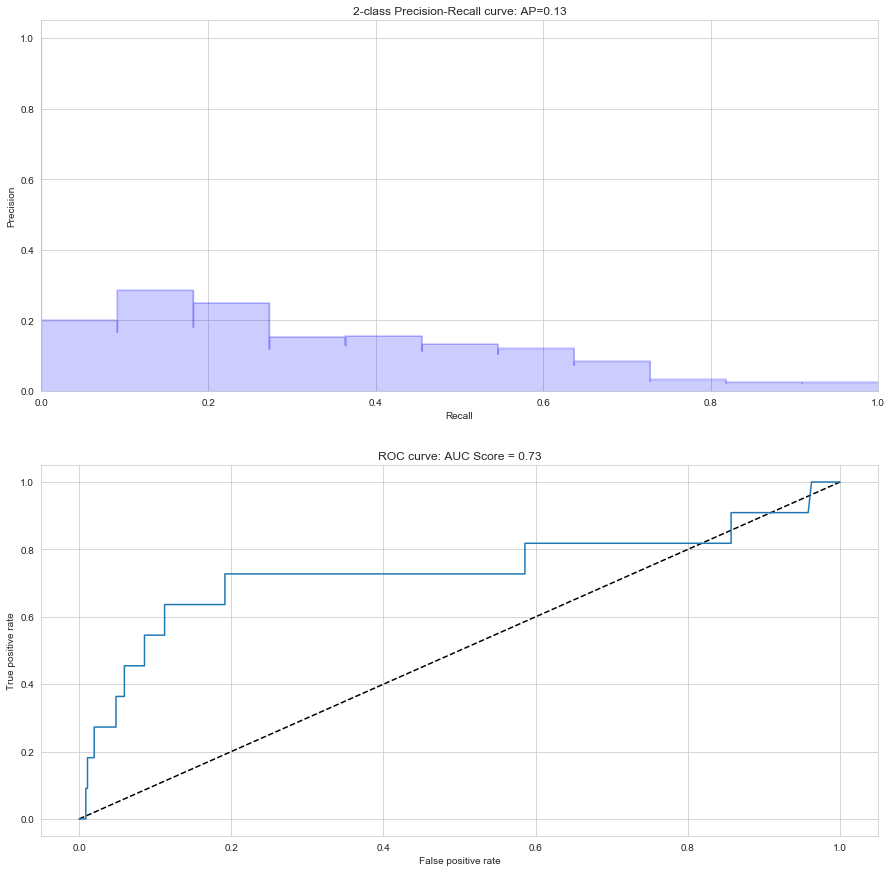

In [17]:
y_score = proba_sm[2]
precision, recall, thresholds = precision_recall_curve(y_t[2], y_score)
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_t[2], y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))
from sklearn.utils.fixes import signature
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.figure(figsize=(15,15))
plt.subplot(2, 1, 1)
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
plt.subplot(2,1,2)
fpr, tpr, _ = roc_curve(y_t[2], y_score)
auc_score = roc_auc_score(y_t[2], y_score)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve: AUC Score = {0:0.2f}'.format(
          auc_score))
plt.show()

### Extra-Trees Classifier

In [17]:
clf = ExtraTreesClassifier(criterion = 'entropy', max_features = 'auto', min_samples_leaf = 2, min_samples_split = 2,
                            n_estimators = 500)

In [18]:
AUC_LR_sm = []
AUC_LR = []
proba_sm = []
proba = []
y_t = []
y = df['crisisST'].values
X = df.drop(['crisisST'], axis=1).values
scaler = StandardScaler()
X  = scaler.fit_transform(X)
sm = SMOTE(0.5,random_state=42)
tscv = TimeSeriesSplit(n_splits=n)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_t.append(y_test)
    X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
    clf.fit(X_train_sm, y_train_sm)
    y_proba1 = clf.predict_proba(X_test)
    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_test)
    AUC_LR.append(roc_auc_score(y_test, y_proba[:,1]))
    proba.append(list(y_proba[:,1]))
    AUC_LR_sm.append(roc_auc_score(y_test, y_proba1[:,1]))
    proba_sm.append(list(y_proba1[:,1]))

In [19]:
def conf_mat(prob, AUC):
    for i in range(n):
        y_pred = []
        for j in range(len(prob[i])):
            if prob[i][j]>0.5:
                y_pred.append(1)
            else: 
                y_pred.append(0)
        print( "-"*80)
        print('AUC Score:', AUC[i])
        print('Confusion_Matrix', i+1)
        print(confusion_matrix(y_t[i],y_pred))
conf_mat(proba, AUC_LR), conf_mat(proba_sm, AUC_LR_sm)

--------------------------------------------------------------------------------
AUC Score: 0.5368831168831169
Confusion_Matrix 1
[[350   0]
 [ 22   0]]
--------------------------------------------------------------------------------
AUC Score: 0.5391589020397884
Confusion_Matrix 2
[[361   0]
 [ 11   0]]
--------------------------------------------------------------------------------
AUC Score: 0.7256756756756757
Confusion_Matrix 3
[[370   0]
 [  2   0]]
--------------------------------------------------------------------------------
AUC Score: 0.6197426239799121
Confusion_Matrix 4
[[354   0]
 [ 18   0]]
--------------------------------------------------------------------------------
AUC Score: 0.4836363636363637
Confusion_Matrix 1
[[350   0]
 [ 22   0]]
--------------------------------------------------------------------------------
AUC Score: 0.6280533870561572
Confusion_Matrix 2
[[361   0]
 [ 11   0]]
--------------------------------------------------------------------------------
A

(None, None)

### Decision Tree Classifier

In [20]:
clf = DecisionTreeClassifier()

In [21]:
AUC_LR_sm = []
AUC_LR = []
proba_sm = []
proba = []
y_t = []
y = df['crisisST'].values
X = df.drop(['crisisST'], axis=1).values
scaler = StandardScaler()
X  = scaler.fit_transform(X)
sm = SMOTE(0.5,random_state=42)
tscv = TimeSeriesSplit(n_splits=n)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_t.append(y_test)
    X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
    clf.fit(X_train_sm, y_train_sm)
    y_proba1 = clf.predict_proba(X_test)
    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_test)
    AUC_LR.append(roc_auc_score(y_test, y_proba[:,1]))
    proba.append(list(y_proba[:,1]))
    AUC_LR_sm.append(roc_auc_score(y_test, y_proba1[:,1]))
    proba_sm.append(list(y_proba1[:,1]))

In [22]:
def conf_mat(prob, AUC):
    for i in range(n):
        y_pred = []
        for j in range(len(prob[i])):
            if prob[i][j]>0.5:
                y_pred.append(1)
            else: 
                y_pred.append(0)
        print( "-"*80)
        print('AUC Score:', AUC[i])
        print('Confusion_Matrix', i+1)
        print(confusion_matrix(y_t[i],y_pred))
conf_mat(proba, AUC_LR), conf_mat(proba_sm, AUC_LR_sm)

--------------------------------------------------------------------------------
AUC Score: 0.49558441558441557
Confusion_Matrix 1
[[331  19]
 [ 21   1]]
--------------------------------------------------------------------------------
AUC Score: 0.4845127171996978
Confusion_Matrix 2
[[317  44]
 [ 10   1]]
--------------------------------------------------------------------------------
AUC Score: 0.49864864864864866
Confusion_Matrix 3
[[369   1]
 [  2   0]]
--------------------------------------------------------------------------------
AUC Score: 0.5
Confusion_Matrix 4
[[354   0]
 [ 18   0]]
--------------------------------------------------------------------------------
AUC Score: 0.46285714285714286
Confusion_Matrix 1
[[324  26]
 [ 22   0]]
--------------------------------------------------------------------------------
AUC Score: 0.5410475950642155
Confusion_Matrix 2
[[325  36]
 [  9   2]]
--------------------------------------------------------------------------------
AUC Score: 0.

(None, None)

### BaggingClassifier

In [23]:
clf = BaggingClassifier()

In [24]:
AUC_LR_sm = []
AUC_LR = []
proba_sm = []
proba = []
y_t = []
y = df['crisisST'].values
X = df.drop(['crisisST'], axis=1).values
scaler = StandardScaler()
X  = scaler.fit_transform(X)
sm = SMOTE(0.5,random_state=42)
tscv = TimeSeriesSplit(n_splits=n)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_t.append(y_test)
    X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
    clf.fit(X_train_sm, y_train_sm)
    y_proba1 = clf.predict_proba(X_test)
    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_test)
    AUC_LR.append(roc_auc_score(y_test, y_proba[:,1]))
    proba.append(list(y_proba[:,1]))
    AUC_LR_sm.append(roc_auc_score(y_test, y_proba1[:,1]))
    proba_sm.append(list(y_proba1[:,1]))

In [25]:
def conf_mat(prob, AUC):
    for i in range(n):
        y_pred = []
        for j in range(len(prob[i])):
            if prob[i][j]>0.5:
                y_pred.append(1)
            else: 
                y_pred.append(0)
        print( "-"*80)
        print('AUC Score:', AUC[i])
        print('Confusion_Matrix', i+1)
        print(confusion_matrix(y_t[i],y_pred))
conf_mat(proba, AUC_LR), conf_mat(proba_sm, AUC_LR_sm)

--------------------------------------------------------------------------------
AUC Score: 0.5574025974025973
Confusion_Matrix 1
[[341   9]
 [ 22   0]]
--------------------------------------------------------------------------------
AUC Score: 0.5431881138252329
Confusion_Matrix 2
[[361   0]
 [ 11   0]]
--------------------------------------------------------------------------------
AUC Score: 0.4027027027027027
Confusion_Matrix 3
[[370   0]
 [  2   0]]
--------------------------------------------------------------------------------
AUC Score: 0.5178123038292529
Confusion_Matrix 4
[[354   0]
 [ 18   0]]
--------------------------------------------------------------------------------
AUC Score: 0.5107792207792208
Confusion_Matrix 1
[[330  20]
 [ 20   2]]
--------------------------------------------------------------------------------
AUC Score: 0.6203727020901536
Confusion_Matrix 2
[[357   4]
 [ 10   1]]
--------------------------------------------------------------------------------
A

(None, None)

### AdaBoost Classifier

In [26]:
clf = AdaBoostClassifier()

In [27]:
AUC_LR_sm = []
AUC_LR = []
proba_sm = []
proba = []
y_t = []
y = df['crisisST'].values
X = df.drop(['crisisST'], axis=1).values
scaler = StandardScaler()
X  = scaler.fit_transform(X)
sm = SMOTE(0.5,random_state=42)
tscv = TimeSeriesSplit(n_splits=n)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_t.append(y_test)
    X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
    clf.fit(X_train_sm, y_train_sm)
    y_proba1 = clf.predict_proba(X_test)
    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_test)
    AUC_LR.append(roc_auc_score(y_test, y_proba[:,1]))
    proba.append(list(y_proba[:,1]))
    AUC_LR_sm.append(roc_auc_score(y_test, y_proba1[:,1]))
    proba_sm.append(list(y_proba1[:,1]))

In [28]:
def conf_mat(prob, AUC):
    for i in range(n):
        y_pred = []
        for j in range(len(prob[i])):
            if prob[i][j]>0.5:
                y_pred.append(1)
            else: 
                y_pred.append(0)
        print( "-"*80)
        print('AUC Score:', AUC[i])
        print('Confusion_Matrix', i+1)
        print(confusion_matrix(y_t[i],y_pred))
conf_mat(proba, AUC_LR), conf_mat(proba_sm, AUC_LR_sm)

--------------------------------------------------------------------------------
AUC Score: 0.43201298701298707
Confusion_Matrix 1
[[336  14]
 [ 22   0]]
--------------------------------------------------------------------------------
AUC Score: 0.5460841097960212
Confusion_Matrix 2
[[356   5]
 [ 11   0]]
--------------------------------------------------------------------------------
AUC Score: 0.8094594594594594
Confusion_Matrix 3
[[370   0]
 [  2   0]]
--------------------------------------------------------------------------------
AUC Score: 0.6741211550533586
Confusion_Matrix 4
[[354   0]
 [ 18   0]]
--------------------------------------------------------------------------------
AUC Score: 0.45214285714285707
Confusion_Matrix 1
[[302  48]
 [ 21   1]]
--------------------------------------------------------------------------------
AUC Score: 0.6646940317300428
Confusion_Matrix 2
[[361   0]
 [ 11   0]]
--------------------------------------------------------------------------------

(None, None)

### GradientBoostingClassifier

In [29]:
clf = GradientBoostingClassifier()

In [30]:
AUC_LR_sm = []
AUC_LR = []
proba_sm = []
proba = []
y_t = []
y = df['crisisST'].values
X = df.drop(['crisisST'], axis=1).values
scaler = StandardScaler()
X  = scaler.fit_transform(X)
sm = SMOTE(0.5,random_state=42)
tscv = TimeSeriesSplit(n_splits=n)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_t.append(y_test)
    X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
    clf.fit(X_train_sm, y_train_sm)
    y_proba1 = clf.predict_proba(X_test)
    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_test)
    AUC_LR.append(roc_auc_score(y_test, y_proba[:,1]))
    proba.append(list(y_proba[:,1]))
    AUC_LR_sm.append(roc_auc_score(y_test, y_proba1[:,1]))
    proba_sm.append(list(y_proba1[:,1]))

In [31]:
def conf_mat(prob, AUC):
    for i in range(n):
        y_pred = []
        for j in range(len(prob[i])):
            if prob[i][j]>0.5:
                y_pred.append(1)
            else: 
                y_pred.append(0)
        print( "-"*80)
        print('AUC Score:', AUC[i])
        print('Confusion_Matrix', i+1)
        print(confusion_matrix(y_t[i],y_pred))
conf_mat(proba, AUC_LR), conf_mat(proba_sm, AUC_LR_sm)

--------------------------------------------------------------------------------
AUC Score: 0.5442857142857143
Confusion_Matrix 1
[[342   8]
 [ 21   1]]
--------------------------------------------------------------------------------
AUC Score: 0.6056408964996222
Confusion_Matrix 2
[[358   3]
 [ 11   0]]
--------------------------------------------------------------------------------
AUC Score: 0.8027027027027027
Confusion_Matrix 3
[[370   0]
 [  2   0]]
--------------------------------------------------------------------------------
AUC Score: 0.623587570621469
Confusion_Matrix 4
[[354   0]
 [ 18   0]]
--------------------------------------------------------------------------------
AUC Score: 0.4442857142857143
Confusion_Matrix 1
[[341   9]
 [ 21   1]]
--------------------------------------------------------------------------------
AUC Score: 0.753210778141526
Confusion_Matrix 2
[[359   2]
 [ 11   0]]
--------------------------------------------------------------------------------
AUC

(None, None)

### XGBoost Classifier

In [32]:
clf = XGBClassifier()

In [33]:
AUC_LR_sm = []
AUC_LR = []
proba_sm = []
proba = []
y_t = []
y = df['crisisST'].values
X = df.drop(['crisisST'], axis=1).values
scaler = StandardScaler()
X  = scaler.fit_transform(X)
sm = SMOTE(0.5,random_state=42)
tscv = TimeSeriesSplit(n_splits=n)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_t.append(y_test)
    X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
    clf.fit(X_train_sm, y_train_sm)
    y_proba1 = clf.predict_proba(X_test)
    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_test)
    AUC_LR.append(roc_auc_score(y_test, y_proba[:,1]))
    proba.append(list(y_proba[:,1]))
    AUC_LR_sm.append(roc_auc_score(y_test, y_proba1[:,1]))
    proba_sm.append(list(y_proba1[:,1]))

In [34]:
def conf_mat(prob, AUC):
    for i in range(n):
        y_pred = []
        for j in range(len(prob[i])):
            if prob[i][j]>0.5:
                y_pred.append(1)
            else: 
                y_pred.append(0)
        print( "-"*80)
        print('AUC Score:', AUC[i])
        print('Confusion_Matrix', i+1)
        print(confusion_matrix(y_t[i],y_pred))
conf_mat(proba, AUC_LR), conf_mat(proba_sm, AUC_LR_sm)

--------------------------------------------------------------------------------
AUC Score: 0.5403896103896104
Confusion_Matrix 1
[[350   0]
 [ 22   0]]
--------------------------------------------------------------------------------
AUC Score: 0.5321077814152606
Confusion_Matrix 2
[[361   0]
 [ 11   0]]
--------------------------------------------------------------------------------
AUC Score: 0.8824324324324324
Confusion_Matrix 3
[[370   0]
 [  2   0]]
--------------------------------------------------------------------------------
AUC Score: 0.5912586315128688
Confusion_Matrix 4
[[354   0]
 [ 18   0]]
--------------------------------------------------------------------------------
AUC Score: 0.45974025974025967
Confusion_Matrix 1
[[329  21]
 [ 21   1]]
--------------------------------------------------------------------------------
AUC Score: 0.7620246789221858
Confusion_Matrix 2
[[361   0]
 [ 11   0]]
--------------------------------------------------------------------------------


(None, None)

### KNeighbors Classifier

In [35]:
clf = KNeighborsClassifier(5)

In [36]:
AUC_LR_sm = []
AUC_LR = []
proba_sm = []
proba = []
y_t = []
y = df['crisisST'].values
X = df.drop(['crisisST'], axis=1).values
scaler = StandardScaler()
X  = scaler.fit_transform(X)
sm = SMOTE(0.5,random_state=42)
tscv = TimeSeriesSplit(n_splits=n)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_t.append(y_test)
    X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
    clf.fit(X_train_sm, y_train_sm)
    y_proba1 = clf.predict_proba(X_test)
    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_test)
    AUC_LR.append(roc_auc_score(y_test, y_proba[:,1]))
    proba.append(list(y_proba[:,1]))
    AUC_LR_sm.append(roc_auc_score(y_test, y_proba1[:,1]))
    proba_sm.append(list(y_proba1[:,1]))

In [37]:
def conf_mat(prob, AUC):
    for i in range(n):
        y_pred = []
        for j in range(len(prob[i])):
            if prob[i][j]>0.5:
                y_pred.append(1)
            else: 
                y_pred.append(0)
        print( "-"*80)
        print('AUC Score:', AUC[i])
        print('Confusion_Matrix', i+1)
        print(confusion_matrix(y_t[i],y_pred))
conf_mat(proba, AUC_LR), conf_mat(proba_sm, AUC_LR_sm)

--------------------------------------------------------------------------------
AUC Score: 0.5215584415584416
Confusion_Matrix 1
[[350   0]
 [ 22   0]]
--------------------------------------------------------------------------------
AUC Score: 0.595441954167716
Confusion_Matrix 2
[[361   0]
 [ 11   0]]
--------------------------------------------------------------------------------
AUC Score: 0.49864864864864866
Confusion_Matrix 3
[[370   0]
 [  2   0]]
--------------------------------------------------------------------------------
AUC Score: 0.4887005649717514
Confusion_Matrix 4
[[354   0]
 [ 18   0]]
--------------------------------------------------------------------------------
AUC Score: 0.530974025974026
Confusion_Matrix 1
[[281  69]
 [ 17   5]]
--------------------------------------------------------------------------------
AUC Score: 0.6800554016620498
Confusion_Matrix 2
[[331  30]
 [  9   2]]
--------------------------------------------------------------------------------
AU

(None, None)

### Naive Bayes

In [38]:
clf = GaussianNB()

In [39]:
AUC_LR_sm = []
AUC_LR = []
proba_sm = []
proba = []
y_t = []
y = df['crisisST'].values
X = df.drop(['crisisST'], axis=1).values
scaler = StandardScaler()
X  = scaler.fit_transform(X)
sm = SMOTE(0.5,random_state=42)
tscv = TimeSeriesSplit(n_splits=n)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_t.append(y_test)
    X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
    clf.fit(X_train_sm, y_train_sm)
    y_proba1 = clf.predict_proba(X_test)
    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_test)
    AUC_LR.append(roc_auc_score(y_test, y_proba[:,1]))
    proba.append(list(y_proba[:,1]))
    AUC_LR_sm.append(roc_auc_score(y_test, y_proba1[:,1]))
    proba_sm.append(list(y_proba1[:,1]))

In [40]:
def conf_mat(prob, AUC):
    for i in range(n):
        y_pred = []
        for j in range(len(prob[i])):
            if prob[i][j]>0.5:
                y_pred.append(1)
            else: 
                y_pred.append(0)
        print( "-"*80)
        print('AUC Score:', AUC[i])
        print('Confusion_Matrix', i+1)
        print(confusion_matrix(y_t[i],y_pred))
conf_mat(proba, AUC_LR), conf_mat(proba_sm, AUC_LR_sm)

--------------------------------------------------------------------------------
AUC Score: 0.45857142857142863
Confusion_Matrix 1
[[316  34]
 [ 22   0]]
--------------------------------------------------------------------------------
AUC Score: 0.7433895744145051
Confusion_Matrix 2
[[ 64 297]
 [  0  11]]
--------------------------------------------------------------------------------
AUC Score: 0.31756756756756754
Confusion_Matrix 3
[[  8 362]
 [  0   2]]
--------------------------------------------------------------------------------
AUC Score: 0.3771186440677966
Confusion_Matrix 4
[[ 17 337]
 [  3  15]]
--------------------------------------------------------------------------------
AUC Score: 0.5015584415584415
Confusion_Matrix 1
[[343   7]
 [ 22   0]]
--------------------------------------------------------------------------------
AUC Score: 0.7277763787459077
Confusion_Matrix 2
[[ 79 282]
 [  1  10]]
--------------------------------------------------------------------------------

(None, None)

### Linear Discriminant Analysis

In [41]:
clf = LinearDiscriminantAnalysis()

In [42]:
AUC_LR_sm = []
AUC_LR = []
proba_sm = []
proba = []
y_t = []
y = df['crisisST'].values
X = df.drop(['crisisST'], axis=1).values
scaler = StandardScaler()
X  = scaler.fit_transform(X)
sm = SMOTE(0.5,random_state=42)
tscv = TimeSeriesSplit(n_splits=n)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_t.append(y_test)
    X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
    clf.fit(X_train_sm, y_train_sm)
    y_proba1 = clf.predict_proba(X_test)
    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_test)
    AUC_LR.append(roc_auc_score(y_test, y_proba[:,1]))
    proba.append(list(y_proba[:,1]))
    AUC_LR_sm.append(roc_auc_score(y_test, y_proba1[:,1]))
    proba_sm.append(list(y_proba1[:,1]))

In [43]:
def conf_mat(prob, AUC):
    for i in range(n):
        y_pred = []
        for j in range(len(prob[i])):
            if prob[i][j]>0.5:
                y_pred.append(1)
            else: 
                y_pred.append(0)
        print( "-"*80)
        print('AUC Score:', AUC[i])
        print('Confusion_Matrix', i+1)
        print(confusion_matrix(y_t[i],y_pred))
conf_mat(proba, AUC_LR), conf_mat(proba_sm, AUC_LR_sm)

--------------------------------------------------------------------------------
AUC Score: 0.4554545454545455
Confusion_Matrix 1
[[344   6]
 [ 22   0]]
--------------------------------------------------------------------------------
AUC Score: 0.6056408964996223
Confusion_Matrix 2
[[361   0]
 [ 11   0]]
--------------------------------------------------------------------------------
AUC Score: 0.31351351351351353
Confusion_Matrix 3
[[370   0]
 [  2   0]]
--------------------------------------------------------------------------------
AUC Score: 0.4891713747645951
Confusion_Matrix 4
[[354   0]
 [ 18   0]]
--------------------------------------------------------------------------------
AUC Score: 0.4325974025974026
Confusion_Matrix 1
[[296  54]
 [ 20   2]]
--------------------------------------------------------------------------------
AUC Score: 0.6212540921682196
Confusion_Matrix 2
[[361   0]
 [ 11   0]]
--------------------------------------------------------------------------------


(None, None)

### Quadratic Discriminant Analysis

In [44]:
clf = QuadraticDiscriminantAnalysis()

In [45]:
AUC_LR_sm = []
AUC_LR = []
proba_sm = []
proba = []
y_t = []
y = df['crisisST'].values
X = df.drop(['crisisST'], axis=1).values
scaler = StandardScaler()
X  = scaler.fit_transform(X)
sm = SMOTE(0.5,random_state=42)
tscv = TimeSeriesSplit(n_splits=n)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_t.append(y_test)
    X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
    clf.fit(X_train_sm, y_train_sm)
    y_proba1 = clf.predict_proba(X_test)
    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_test)
    AUC_LR.append(roc_auc_score(y_test, y_proba[:,1]))
    proba.append(list(y_proba[:,1]))
    AUC_LR_sm.append(roc_auc_score(y_test, y_proba1[:,1]))
    proba_sm.append(list(y_proba1[:,1]))

In [46]:
def conf_mat(prob, AUC):
    for i in range(n):
        y_pred = []
        for j in range(len(prob[i])):
            if prob[i][j]>0.5:
                y_pred.append(1)
            else: 
                y_pred.append(0)
        print( "-"*80)
        print('AUC Score:', AUC[i])
        print('Confusion_Matrix', i+1)
        print(confusion_matrix(y_t[i],y_pred))
conf_mat(proba, AUC_LR), conf_mat(proba_sm, AUC_LR_sm)

--------------------------------------------------------------------------------
AUC Score: 0.46532467532467536
Confusion_Matrix 1
[[346   4]
 [ 22   0]]
--------------------------------------------------------------------------------
AUC Score: 0.775623268698061
Confusion_Matrix 2
[[120 241]
 [  1  10]]
--------------------------------------------------------------------------------
AUC Score: 0.5297297297297296
Confusion_Matrix 3
[[ 21 349]
 [  0   2]]
--------------------------------------------------------------------------------
AUC Score: 0.5569679849340866
Confusion_Matrix 4
[[131 223]
 [  3  15]]
--------------------------------------------------------------------------------
AUC Score: 0.4794805194805195
Confusion_Matrix 1
[[348   2]
 [ 22   0]]
--------------------------------------------------------------------------------
AUC Score: 0.7386048854192899
Confusion_Matrix 2
[[158 203]
 [  2   9]]
--------------------------------------------------------------------------------
A

(None, None)

### SVM Classifier

In [54]:
clf = svm.SVC(decision_function_shape='ovo', probability=True)

In [55]:
AUC_LR_sm = []
AUC_LR = []
proba_sm = []
proba = []
y_t = []
y = df['crisisST'].values
X = df.drop(['crisisST'], axis=1).values
scaler = StandardScaler()
X  = scaler.fit_transform(X)
sm = SMOTE(0.5,random_state=42)
tscv = TimeSeriesSplit(n_splits=n)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_t.append(y_test)
    X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
    clf.fit(X_train_sm, y_train_sm)
    y_proba1 = clf.predict_proba(X_test)
    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_test)
    AUC_LR.append(roc_auc_score(y_test, y_proba[:,1]))
    proba.append(list(y_proba[:,1]))
    AUC_LR_sm.append(roc_auc_score(y_test, y_proba1[:,1]))
    proba_sm.append(list(y_proba1[:,1]))

In [56]:
def conf_mat(prob, AUC):
    for i in range(n):
        y_pred = []
        for j in range(len(prob[i])):
            if prob[i][j]>0.5:
                y_pred.append(1)
            else: 
                y_pred.append(0)
        print( "-"*80)
        print('AUC Score:', AUC[i])
        print('Confusion_Matrix', i+1)
        print(confusion_matrix(y_t[i],y_pred))
conf_mat(proba, AUC_LR), conf_mat(proba_sm, AUC_LR_sm)

--------------------------------------------------------------------------------
AUC Score: 0.525974025974026
Confusion_Matrix 1
[[350   0]
 [ 22   0]]
--------------------------------------------------------------------------------
AUC Score: 0.17451523545706374
Confusion_Matrix 2
[[361   0]
 [ 11   0]]
--------------------------------------------------------------------------------
AUC Score: 0.5270270270270271
Confusion_Matrix 3
[[370   0]
 [  2   0]]
--------------------------------------------------------------------------------
AUC Score: 0.4967043314500941
Confusion_Matrix 4
[[354   0]
 [ 18   0]]
--------------------------------------------------------------------------------
AUC Score: 0.538051948051948
Confusion_Matrix 1
[[332  18]
 [ 20   2]]
--------------------------------------------------------------------------------
AUC Score: 0.8670360110803325
Confusion_Matrix 2
[[359   2]
 [ 10   1]]
--------------------------------------------------------------------------------
AU

(None, None)

### Plots

Average precision-recall score: 0.27


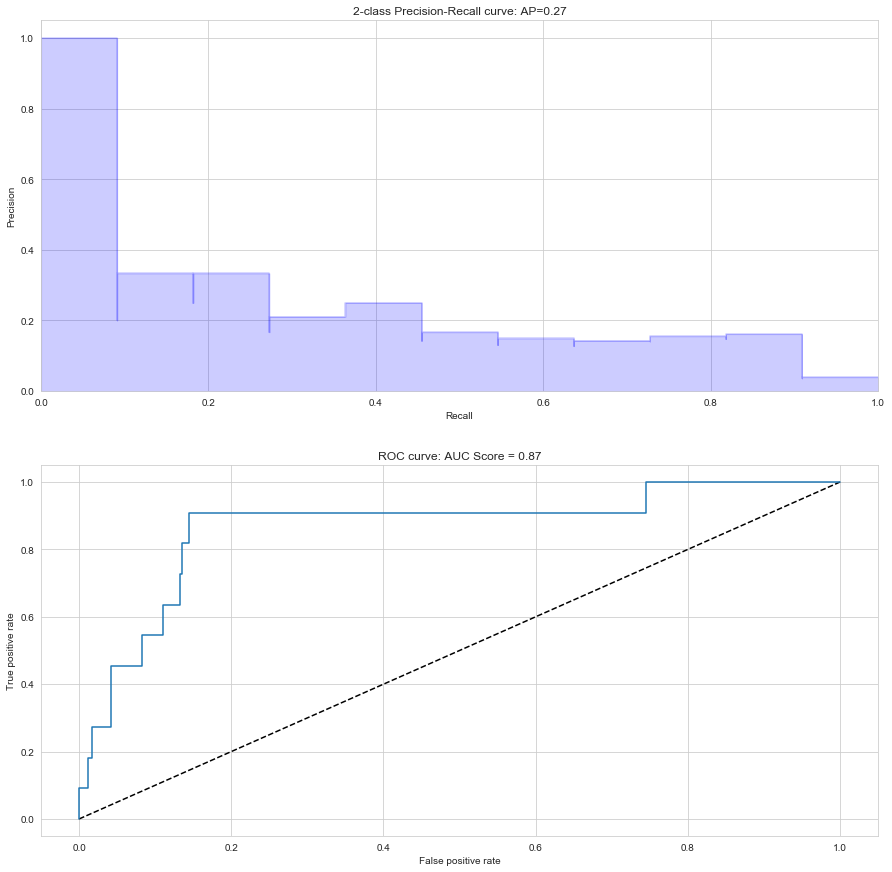

In [57]:
y_score = proba_sm[1]
y_test = y_t[1]
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))
from sklearn.utils.fixes import signature
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.figure(figsize=(15,15))
plt.subplot(2, 1, 1)
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
plt.subplot(2,1,2)
fpr, tpr, _ = roc_curve(y_test, y_score)
auc_score = roc_auc_score(y_test, y_score)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve: AUC Score = {0:0.2f}'.format(
          auc_score))
plt.show()

### SGD Classifier

In [50]:
clf = SGDClassifier(loss = 'log')

In [51]:
AUC_LR_sm = []
AUC_LR = []
proba_sm = []
proba = []
y_t = []
y = df['crisisST'].values
X = df.drop(['crisisST'], axis=1).values
scaler = StandardScaler()
X  = scaler.fit_transform(X)
sm = SMOTE(0.5,random_state=42)
tscv = TimeSeriesSplit(n_splits=n)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_t.append(y_test)
    X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
    clf.fit(X_train_sm, y_train_sm)
    y_proba1 = clf.predict_proba(X_test)
    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_test)
    AUC_LR.append(roc_auc_score(y_test, y_proba[:,1]))
    proba.append(list(y_proba[:,1]))
    AUC_LR_sm.append(roc_auc_score(y_test, y_proba1[:,1]))
    proba_sm.append(list(y_proba1[:,1]))

In [52]:
def conf_mat(prob, AUC):
    for i in range(n):
        y_pred = []
        for j in range(len(prob[i])):
            if prob[i][j]>0.5:
                y_pred.append(1)
            else: 
                y_pred.append(0)
        print( "-"*80)
        print('AUC Score:', AUC[i])
        print('Confusion_Matrix', i+1)
        print(confusion_matrix(y_t[i],y_pred))
conf_mat(proba, AUC_LR), conf_mat(proba_sm, AUC_LR_sm)

--------------------------------------------------------------------------------
AUC Score: 0.42467532467532465
Confusion_Matrix 1
[[345   5]
 [ 22   0]]
--------------------------------------------------------------------------------
AUC Score: 0.7942583732057418
Confusion_Matrix 2
[[353   8]
 [ 10   1]]
--------------------------------------------------------------------------------
AUC Score: 0.28648648648648645
Confusion_Matrix 3
[[370   0]
 [  2   0]]
--------------------------------------------------------------------------------
AUC Score: 0.6892655367231638
Confusion_Matrix 4
[[354   0]
 [ 18   0]]
--------------------------------------------------------------------------------
AUC Score: 0.345974025974026
Confusion_Matrix 1
[[312  38]
 [ 21   1]]
--------------------------------------------------------------------------------
AUC Score: 0.6043817678166707
Confusion_Matrix 2
[[235 126]
 [  6   5]]
--------------------------------------------------------------------------------


(None, None)